In [4]:
import os

os.chdir('/home/papafrita/projects/soluGNN/solugnn')

from model_service import ModelService


[WARNING 11-12 12:04:20] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [2]:
gcn_multi = ModelService(multi_model=True)
gcn_multi.load_models()

/home/papafrita/projects/soluGNN/solugnn/model_service.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.models = [torch.load(model_name) for model_name in model_nam

5 models found and loaded.


In [3]:
gcn_single = ModelService()
gcn_single.load_model('optimized_gcn_seed_7.pt')

Model optimized_gcn_seed_7.pt loaded.


In [4]:
import pandas as pd

test_data = pd.read_csv('../data/test.csv')
test_data['predicted'] = test_data['smiles'].apply(gcn_single.get_pred)
test_data.head()

,Unnamed: 0,iupac,smiles,expt,calc,predicted
0,178,1-pyrrolidin-1-ylethanone,CC(=O)N1CCCC1,-9.80,-7.831,-4.719940
1,466,propanenitrile,CCC#N,-3.84,-2.491,-3.776811
2,565,1-bromo-pentane,CCCCCBr,-0.10,0.824,0.723713
3,51,2-methylbutan-1-ol,CC[C@@H](C)CO,-4.42,-2.995,-4.148237
4,34,N-ethylethanamine,CCNCC,-4.07,-2.986,-4.751862


In [5]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(test_data['expt'], test_data['predicted'])

1.5381961635577326

In [13]:
multipred_mean = []
multipred_std = []
for smile in test_data.smiles:
    mean, sd = gcn_multi.get_preds(smile)
    multipred_mean.append(mean)
    multipred_std.append(sd)

test_data['multipred_mean'] = multipred_mean
test_data['multipred_std'] = multipred_std
coef_var = test_data['multipred_std'] / test_data['multipred_mean'].abs()
test_data['coef_var'] = coef_var * 100
test_data.head()

,Unnamed: 0,iupac,smiles,expt,calc,predicted,multipred_mean,multipred_std,coef_var
0,178,1-pyrrolidin-1-ylethanone,CC(=O)N1CCCC1,-9.80,-7.831,-4.719940,-4.924388,0.668940,13.584225
1,466,propanenitrile,CCC#N,-3.84,-2.491,-3.776811,-3.983506,0.211121,5.299888
2,565,1-bromo-pentane,CCCCCBr,-0.10,0.824,0.723713,0.275283,0.445959,162.000320
3,51,2-methylbutan-1-ol,CC[C@@H](C)CO,-4.42,-2.995,-4.148237,-4.345874,0.182581,4.201249
4,34,N-ethylethanamine,CCNCC,-4.07,-2.986,-4.751862,-4.534290,0.174737,3.853681


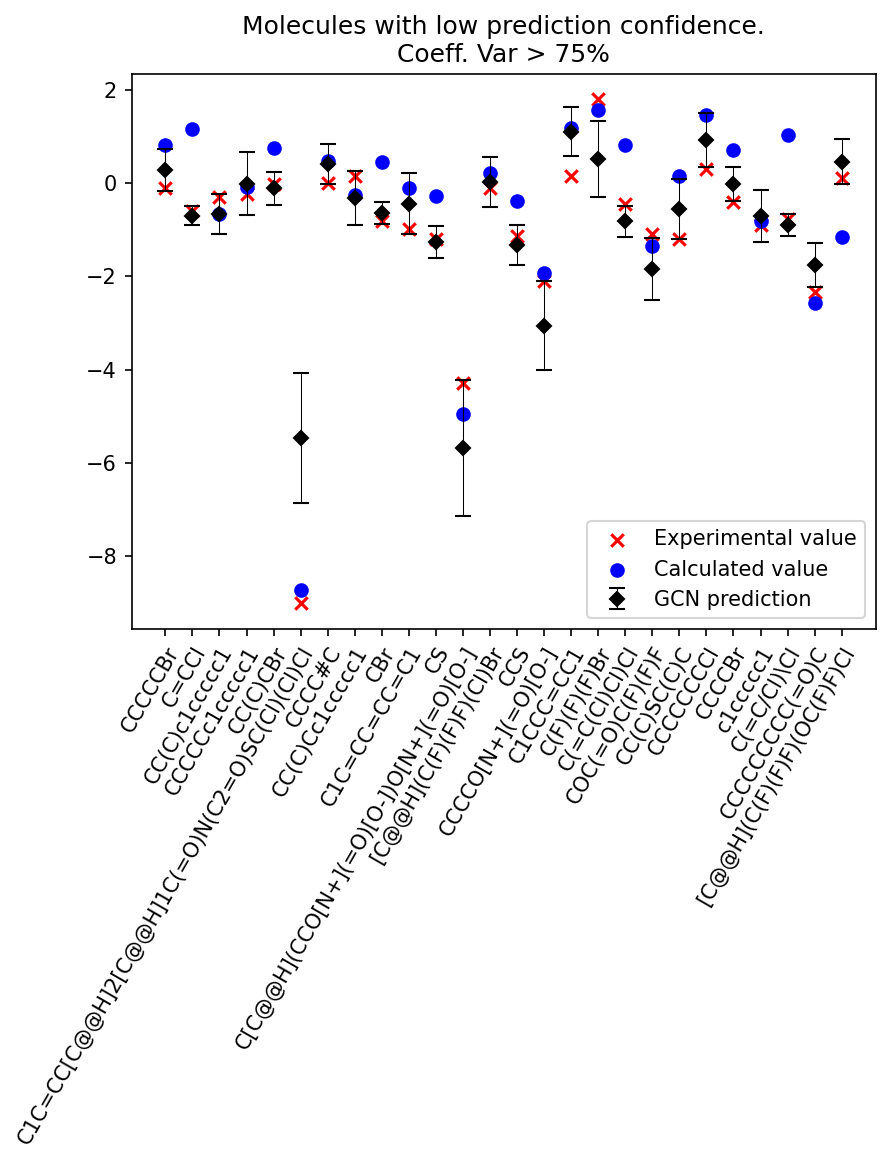

In [81]:
import matplotlib.pyplot as plt

low_conf_mask = test_data['coef_var'] > 25
test_data_low_conf = test_data[low_conf_mask]

plt.figure(dpi=150)
plt.scatter(test_data_low_conf['smiles'],
            test_data_low_conf['expt'],
            marker='x',
            c='red')

plt.scatter(test_data_low_conf['smiles'],
            test_data_low_conf['calc'],
            marker='o',
            c='blue')

plt.errorbar(test_data_low_conf['smiles'],
             test_data_low_conf['multipred_mean'],
             yerr=test_data_low_conf['multipred_std'],
             fmt='kD',
             ecolor='k',
             capsize=4,
             elinewidth=0.5,
             markersize=5)
plt.legend(['Experimental value',
            'Calculated value',
            'GCN prediction',],
            loc='lower right'
            )
plt.title("Molecules with low prediction confidence.\nCoeff. Var > 75%")
plt.xticks(rotation=60, rotation_mode='anchor', ha='right');

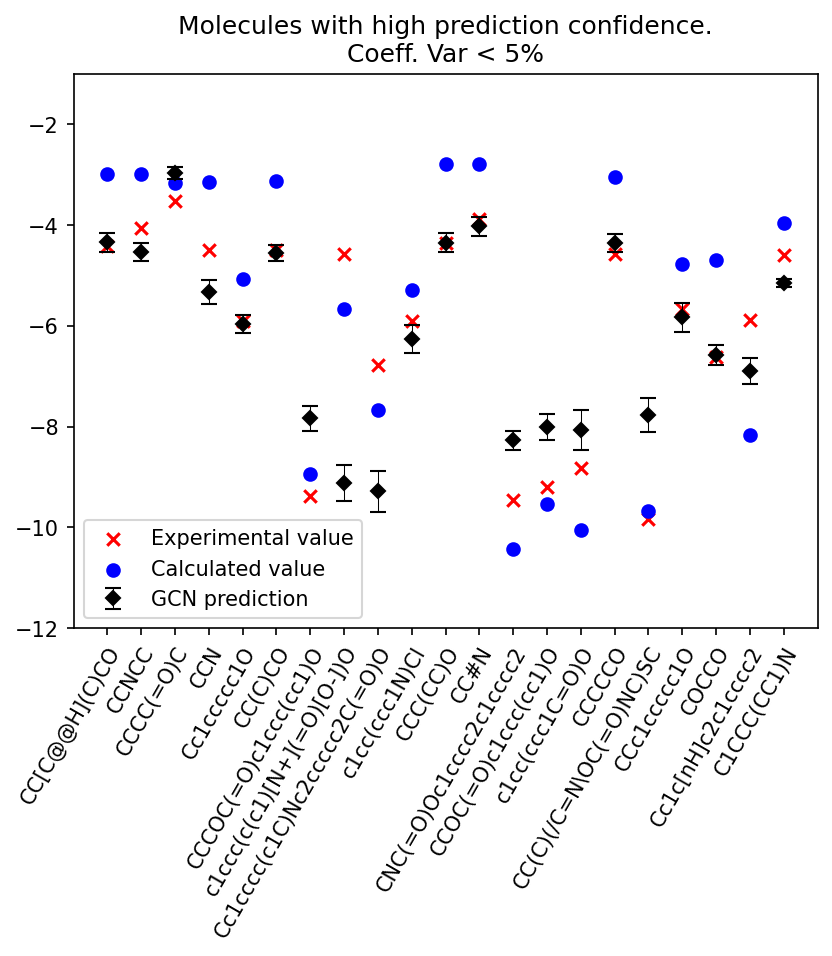

In [82]:
high_conf_mask = test_data['coef_var'] < 5
test_data_high_conf = test_data[high_conf_mask]

plt.figure(dpi=150)
plt.errorbar(test_data_high_conf['smiles'],
        test_data_high_conf['multipred_mean'],
        yerr=test_data_high_conf['multipred_std'],
        fmt='kD',
        ecolor='k',
        capsize=4,
        elinewidth=0.5,
        markersize=5)

plt.scatter(test_data_high_conf['smiles'],
            test_data_high_conf['expt'],
            marker='x',
            c='red')

plt.scatter(test_data_high_conf['smiles'],
            test_data_high_conf['calc'],
            marker='o',
            c='blue')

plt.title("Molecules with high prediction confidence.\nCoeff. Var < 5%")

plt.legend(['Experimental value',
            'Calculated value',
            'GCN prediction',],
            loc='lower left'
            )
plt.ylim([-12, -1])
plt.xticks(rotation=60, rotation_mode='anchor', ha='right');

In [15]:
from pathlib import Path

model_path = Path('../models/')

In [16]:
model_path.absolute().as_posix()

'/home/papafrita/projects/soluGNN/notebooks/../models'

In [1]:
import os

os.chdir('/home/papafrita/projects/soluGNN/solugnn')

from config import settings

path = settings.model_path
name = 'model.pth'

f"{path.as_posix()}/{name}"

'../models/model.pth'

In [2]:
[x for x in path.glob('*.pt')]

[PosixPath('../models/optimized_gcn_seed_44.pt'),
 PosixPath('../models/optimized_gcn_seed_16.pt'),
 PosixPath('../models/optimized_gcn_seed_248.pt'),
 PosixPath('../models/optimized_gcn_seed_7.pt'),
 PosixPath('../models/optimized_gcn_seed_171.pt')]

In [ ]:
import torch
from solugnn.model import ChemGCN, ConvolutionLayer, PoolingLayer

torch.serialization.clear_safe_globals()
torch.serialization.add_safe_globals([set,
                                      ChemGCN,
                                      ConvolutionLayer,
                                      PoolingLayer,
                                      torch.nn.Linear,
                                      torch.nn.modules.container.ModuleList,
                                      torch.nn.modules.activation.LeakyReLU,
                                      torch.nn.modules.dropout.Dropout,
                                      ])
torch.serialization.get_safe_globals()

ModuleNotFoundError: No module named 'model'

In [26]:
torch.load('../models/optimized_gcn_seed_7.pt', weights_only=True)

ChemGCN(
  (init_transform): Linear(in_features=60, out_features=100, bias=True)
  (conv_layers): ModuleList(
    (0-1): 2 x ConvolutionLayer(
      (conv_linear): Linear(in_features=100, out_features=100, bias=True)
      (conv_activation): LeakyReLU(negative_slope=0.01)
    )
  )
  (pooling): PoolingLayer()
  (pooling_activation): LeakyReLU(negative_slope=0.01)
  (pooled_to_hidden): Linear(in_features=100, out_features=60, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=60, out_features=60, bias=True)
  )
  (hidden_activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden_to_output): Linear(in_features=60, out_features=1, bias=True)
)